# Batch API

In this notebook, we will guide you through an example of extracting information from multiple receipts using the Mistral batch API and returning the data in a pandas DataFrame.

In [1]:
!pip install mistralai datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.9/256.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Get receipts images

We found some receipts images from Hugging Face:

In [2]:
import pandas as pd
from datasets import load_dataset

# Replace 'dataset_name' with the actual name of the dataset you want to download
dataset_name = 'shirastromer/supermarket-receipts'  # Example: IMDB dataset

# Load the dataset
dataset = load_dataset(dataset_name)

# Convert the dataset to a pandas DataFrame
# Assuming you want to load the 'train' split of the dataset
df = pd.DataFrame(dataset['train'])

# Display the first few rows of the DataFrame
df.head()


README.md:   0%|          | 0.00/509 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/60.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/153 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/39 [00:00<?, ? examples/s]

,image,receiptId,text
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,label-studio-91,"{\n ""store_name"": """",\n ""store_addr"": """"..."
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,label-studio-75,"{\n ""store_name"": """",\n ""store_addr"": """"..."
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,label-studio-201,"{\n ""store_name"": """",\n ""store_addr"": """"..."
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,label-studio-138,"{\n ""store_name"": """",\n ""store_addr"": """",\n ..."
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,label-studio-109,"{\n ""store_name"": """",\n ""store_addr"": """"..."


# Take a look at one image

Let's start with one image and get info from this image with Pixtral Large.

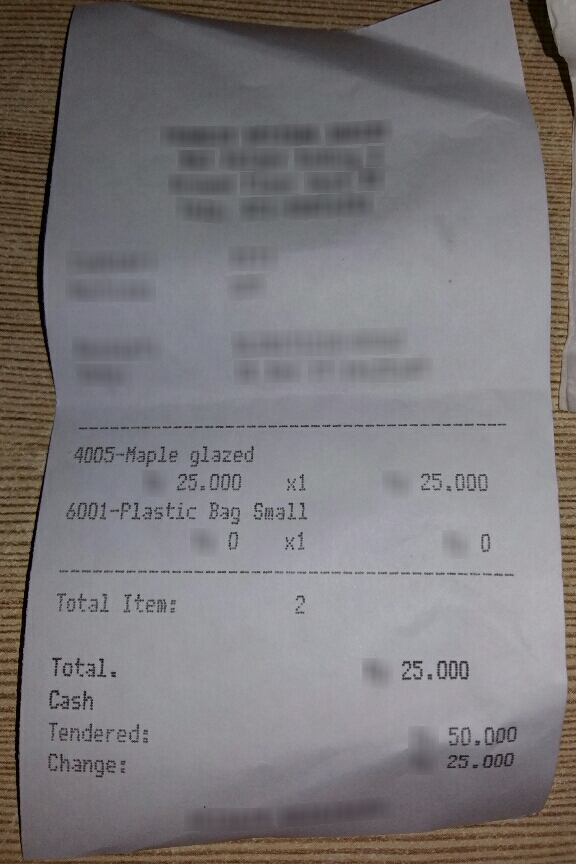

In [3]:
# take a look at an image
df.image[1]

let's extract information from a single image using the Mistral API.


In [4]:
import base64
from io import BytesIO
from typing import Any
from PIL.Image import Image

def format_image(image: Image) -> str:
    """
    Converts an image to a base64-encoded string with a JPEG format.

    Args:
        image (Image): The image to be formatted.

    Returns:
        str: The base64-encoded string with a data URI prefix.
    """
    # Convert image to base64
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    image_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

    # Add the prefix for base64 format
    formatted_base64 = f"data:image/jpeg;base64,{image_base64}"
    return formatted_base64


In [5]:
from mistralai import Mistral
import os

api_key = os.environ["MISTRAL_API_KEY"]

client = Mistral(api_key=api_key)

In [6]:
# Define the messages for the chat
# Let's extract name, price, and get category for the item
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": format_image(df.image[1])
            },
            {
                "type": "text",
                "text": "Extract the name and price of each item on the receipt, categorize each item into one of the following categories: 'Medical', 'Food', 'Beverage', 'Travel', or 'Other', and return the results as a well-structured JSON object. The JSON object should include only the fields: name, price, and classification for each item."
            }
        ]
    },
    {"role": "assistant", "content": "{", "prefix": True},
]

# Get the chat response
chat_response = client.chat.complete(
    model="pixtral-large-latest",
    messages=messages,
    response_format = {
          "type": "json_object",
    }

)

# Print the content of the response
print(chat_response.choices[0].message.content)


{
  "items": [
    {
      "name": "Maple glazed",
      "price": 25.000,
      "classification": "Food"
    },
    {
      "name": "Plastic Bag Small",
      "price": 0,
      "classification": "Other"
    }
  ]
}


# Use batch API to process many images

## Create a batch

Let's process 10 images as an example.

In [ ]:
import json
from io import BytesIO

num_samples = 10

list_of_json = []
for idx in range(num_samples):
    request = {
        "custom_id": str(idx),
        "body": {
            "max_tokens": 1000,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": format_image(df.image[idx])
                        },
                        {
                            "type": "text",
                            "text": "Identify the name and price of each item on the receipt, categorize each item into one of the following categories: 'Medical', 'Food', 'Beverage', 'Travel', or 'Other', and return the results as a well-structured JSON object. The JSON object should include only the fields: name, price, and classification for each item."
                        }
                    ]
                },
                {
                    "role": "assistant",
                    "content": "{",
                    "prefix": True
                }
            ],
        "response_format": {"type": "json_object"}
        }
    }
    list_of_json.append(json.dumps(request).encode("utf-8"))

## Upload your batch

In [ ]:
batch_data = client.files.upload(
    file={
        "file_name": "file.jsonl",
        "content": b"\n".join(list_of_json)},
    purpose = "batch"
)

In [ ]:
batch_data

UploadFileOut(id='30f63bb3-6f9e-4dd5-9295-a9cdbdeabf75', object='file', bytes=1769058, created_at=1732400347, filename='file.jsonl', purpose='batch', sample_type='batch_request', source='upload', num_lines=10)

## Create a batch job

In [ ]:
created_job = client.batch.jobs.create(
    input_files=[batch_data.id],
    model="pixtral-large-latest",
    endpoint="/v1/chat/completions",
    metadata={"job_type": "testing"}
)

In [ ]:
created_job

BatchJobOut(id='5befe8c6-b8cb-4858-a068-d600cf5ed73f', input_files=['30f63bb3-6f9e-4dd5-9295-a9cdbdeabf75'], endpoint='/v1/chat/completions', model='pixtral-large-latest', errors=[], status='QUEUED', created_at=1732400351, total_requests=0, completed_requests=0, succeeded_requests=0, failed_requests=0, OBJECT='batch', metadata={'job_type': 'testing'}, output_file=None, error_file=None, started_at=None, completed_at=None)

## Get batch job details

In [ ]:
retrieved_job = client.batch.jobs.get(job_id=created_job.id)
retrieved_job

BatchJobOut(id='5befe8c6-b8cb-4858-a068-d600cf5ed73f', input_files=['30f63bb3-6f9e-4dd5-9295-a9cdbdeabf75'], endpoint='/v1/chat/completions', model='pixtral-large-latest', errors=[], status='SUCCESS', created_at=1732400351, total_requests=10, completed_requests=10, succeeded_requests=10, failed_requests=0, OBJECT='batch', metadata={'job_type': 'testing'}, output_file='950fae83-2802-40c0-a677-c7839a4e238a', error_file=None, started_at=1732400351, completed_at=1732400376)

In [ ]:
print(f"Total requests: {retrieved_job.total_requests}")
print(f"Failed requests: {retrieved_job.failed_requests}")
print(f"Successful requests: {retrieved_job.succeeded_requests}")
print(
    f"Percent done: {round((retrieved_job.succeeded_requests + retrieved_job.failed_requests) / retrieved_job.total_requests, 4) * 100}")


Total requests: 10
Failed requests: 0
Successful requests: 10
Percent done: 100.0


## Get batch results

In [ ]:
output = client.files.download(file_id=retrieved_job.output_file).read().decode("utf-8").strip()

In [ ]:
print(output)

{"id":"0-61c18c3c-1873-4288-9f92-af97f696fb2c","custom_id":"0","response":{"status_code":200,"body":{"id":"7f3874116cb943fea58853d60cf17ff3","object":"chat.completion","model":"pixtral-large-latest","usage":{"prompt_tokens":2898,"completion_tokens":88,"total_tokens":2986},"created":1732400353,"choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","content":"{\n  \"items\": [\n    {\n      \"name\": \"VANCOOLEN\",\n      \"price\": 8182,\n      \"classification\": \"Medical\"\n    },\n    {\n      \"name\": \"PLASTIK 25\",\n      \"price\": 0,\n      \"classification\": \"Other\"\n    }\n  ]\n}","tool_calls":null}}]}},"error":null}
{"id":"1-18219f09-acff-4644-baec-a73b15788364","custom_id":"1","response":{"status_code":200,"body":{"id":"aaee50ed69384fe9ae8e9fe9c4bc0c55","object":"chat.completion","model":"pixtral-large-latest","usage":{"prompt_tokens":2080,"completion_tokens":86,"total_tokens":2166},"created":1732400354,"choices":[{"index":0,"finish_reason":"stop","m

# Extract info to a Pandas dataframe

In [ ]:
# Parse JSON lines
lines = output.strip().split('\n')

# Extract required fields
extracted_data = []
for line in lines:
    parsed_line = json.loads(line)
    custom_id = parsed_line.get("custom_id")
    response = parsed_line.get("response", {})
    body = response.get("body", {})
    choices = body.get("choices", [])

    for choice in choices:
        message_content = choice.get("message", {}).get("content", "")
        # Extract items from the JSON string in "content"
        try:
            items_data = json.loads(message_content.strip('```'))
            items = items_data if isinstance(items_data, list) else items_data.get("items", [])
            for item in items:
                extracted_data.append({
                    "custom_id": custom_id,
                    "name": item.get("name"),
                    "price": item.get("price"),
                    "classification": item.get("classification")
                })
        except json.JSONDecodeError:
            continue

# Create a Pandas DataFrame
df_output = pd.DataFrame(extracted_data)


In [ ]:
df_output

,custom_id,name,price,classification
0,0,VANCOOLEN,8182.000,Medical
1,0,PLASTIK 25,0.000,Other
2,1,Maple glazed,25.000,Food
3,1,Plastic Bag Small,0.000,Other
4,2,DEPT04,24000.000,Other
5,2,DEPT01,22000.000,Other
6,3,TAKOYAKI 12PCS,30000.000,Food
7,4,Jamur Crispy,13500.000,Food
8,4,Nasi Putih,7000.000,Food
9,4,Sambel Kecap,4500.000,Food
